<a href="https://colab.research.google.com/github/mohamedHashem250/DeepLearningArchitecture/blob/main/GAN_Architecture/vanilla-Gan/vanilla_GAN_FCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# In this program, we build the GAN with fully connected neural network to generate Mnist dataset:
#the program follow this article to produce most of the codes: https://towardsdatascience.com/decoding-the-basic-math-in-gan-simplified-version-6fb6b079793
##https://medium.com/@mnkrishn/gan-build-using-tensorflow-3d9ca7cef21f

https://github.com/hboekema/recolour/tree/master/projects/ImageNet/code/architectures/generator

In [ ]:
#import libraries:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#to save the model to link drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#loading dataset:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
#convert the dataset to be 1D
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [ ]:
#normalization step
X_train = X_train.astype('float32') /255.0
X_test = X_test.astype('float32') /255.0

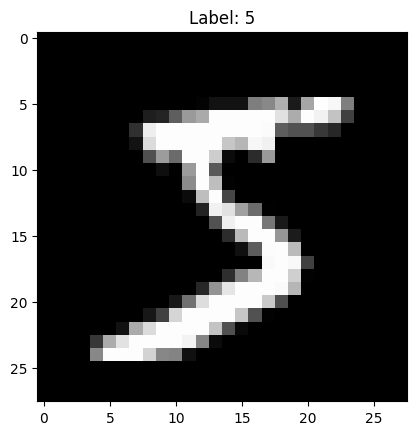

In [ ]:
#y_train[0]
plt.imshow(X_train[0].reshape(28,28),cmap='grey')
plt.title('Label: {}'.format(y_train[0]))
plt.show()

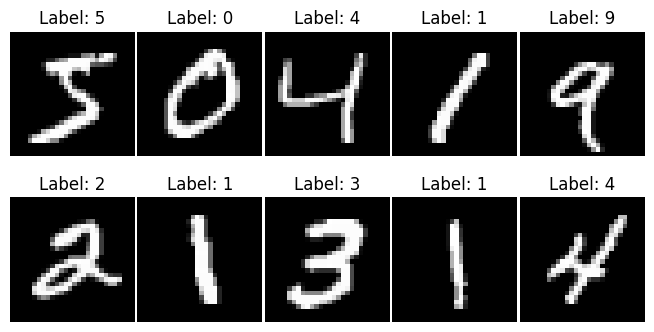

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 5)
for i , axi in enumerate(ax.flat):
  axi.imshow(X_train[i].reshape(28,28), cmap = 'grey')
  axi.set_title('Label: {}'.format(y_train[i]))
  axi.axis('off')
  plt.tight_layout(pad = 0.2)
plt.show()

In [ ]:
#build generator:
class Generator(tf.keras.Model):
  def __init__(self,z_dim = 100, data_dim = 28*28):
    super(Generator, self).__init__()
    self.z_dim = z_dim
    self.data_dim = data_dim
    self.net = tf.keras.Sequential([
        tf.keras.layers.Input(shape =(self.z_dim,)),
        #tf.keras.layers.Dense(units = 256, activation = 'relu'),
        tf.keras.layers.Dense(units = 512, activation = 'relu'),
        tf.keras.layers.Dense(units = self.data_dim , activation = 'sigmoid')
    ])
  def call(self, x):
    return self.net(x)


In [ ]:
class Dicriminator(tf.keras.Model):
  def __init__(self,data_dim = 28*28):
    super(Dicriminator, self).__init__()
    self.net = tf.keras.Sequential([
        tf.keras.layers.Dense(units = 256, activation = 'relu',input_shape = (data_dim,)),
        #tf.keras.layers.Dense(units = 128, activation = 'relu'),
        tf.keras.layers.Dense(units = 1)#binary classifier
    ])
  def call(self, x):
    return self.net(x)

In [ ]:
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
    def compile(self, disc_optimizer, gen_optimizer):
        super(GAN, self).compile()
        self.disc_optimizer = disc_optimizer
        self.gen_optimizer = gen_optimizer
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits = True)
        ####self.loss_metric = tf.keras.metrics.Mean(name = 'loss')
    ####@property
    ####def metrics(self):
    ####  return [self.loss_metric]
    ####def train_step(self, data):

    def Discriminator_loss(self, real_output, fake_output):
        #minimize -[log(D{x}) + log(1-D[G{z}])]
        real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
        fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss
        return disc_loss

    def Generator_loss(self, fake_output):
      #minimize - log(D(G{z}))
      gen_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)
      return gen_loss

    @tf.function
    def train_step(self, data):
        batch_size = tf.shape(data)[0]
        noise = tf.random.normal(shape = (batch_size, self.generator.z_dim))
        with tf.GradientTape() as disc_tape,  tf.GradientTape() as gen_tape:
            #discriminator operations
            generated_data = self.generator(noise)
            real_output = self.discriminator(data)
            fake_output = self.discriminator(generated_data)
            disc_loss = self.Discriminator_loss(real_output, fake_output)
            #generator operations D(G(z))
            gen_loss = self.Generator_loss(fake_output)
        #calculate Gradient
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        #optimization step : update W, B of discriminator
        #apply optimization step: Update W,B of Generator:
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))
        return {"Gen Loss":gen_loss, "Disc Loss":disc_loss}

In [ ]:
# another approach of training:
#         for k in range(self.steps):
#             with tf.GradientTape() as disc_tape:
#                 #discriminator operations
#                 generated_data = self.generator(noise)
#                 real_output = self.discriminator(data)
#                 fake_output = self.discriminator(generated_data)
#                 #disc_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output) + tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
#                 disc_loss = self.Discriminator_loss(real_output, fake_output)
#                 #calculate Gradient
#             disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
#             #optimization step : update W, B of discriminator
#             self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

#         noise = tf.random.normal(shape = (batch_size, self.generator.z_dim))
#         with tf.GradientTape() as gen_tape:
#             #generator operations D(G(z))
#             generated_data = self.generator(noise)
#             fake_output = self.discriminator(generated_data)
#             gen_loss = self.Generator_loss(fake_output)
#         gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
#         self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

In [ ]:
#Hyperparatmeters:
laten_dim = 60
epochs = 1000
batch_size = 128
gen_optim = tf.keras.optimizers.Adam(learning_rate = 0.0001)
disc_optim = tf.keras.optimizers.Adam(learning_rate = 0.0001)
#steps = 5
#Define loss function
#cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits= True)

In [ ]:
# #save image samples from Generator
# def save_imges(epoch, generator, noise):
#   gen_imgs = generator(noise)
#   fig = plt.figure(figsize= (4,4))
#   for i in range(gen_imgs.shape[0]):
#     plt.subplot(4,4,i+1)
#     plt.imshow(gen_imgs[i].numpy().reshape(28,28), cmap = 'gray')
#     plt.axis('off')

#   fig.savefig('gan_img_at_epoch_{:04d}.png'.format(epoch))


In [ ]:
def save_imges(epoch, generator, noise, base_path = '/content/drive/My Drive/GAN_images/'):
  gen_imgs = generator(noise)
  fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(4, 4),
                        # Remove padding and spaces
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        # Remove subplot margins
                        subplot_kw={'aspect': 'equal'}) # Ensure square aspect ratio for images

  for i, ax in enumerate(axs.flat):
    ax.imshow(gen_imgs[i].numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')
  save_dir = base_path+'gan_img_at_epoch_{:04d}'.format(epoch)
  #create directory
  if not os.path.exists(save_dir):
    os.makedirs(save_dir)
  #save image
  fig.savefig(save_dir+ 'gan_img_at_epoch_{:04d}.png'.format(epoch))
  plt.close(fig) # Close the figure to release memory

In [ ]:
#Tensorflow Callbacks:
#note, we create floder for saved images and floder to save models or "weights of the models"
import os
base_path = '/content/drive/My Drive/GAN_images/'
class Training_Callback(tf.keras.callbacks.Callback):
  def __init__(self, z_dim, saving_rate,n_imgs = 16):
    super(Training_Callback, self).__init__()
    self.z_dim = z_dim
    self.saving_rate = saving_rate
    self.noise = tf.random.normal(shape = (n_imgs, self.z_dim))
  def on_epoch_end(self, epoch, logs = None):
    logs =  {}
    #save images
    if epoch % 100 == 0:###############################
      save_imges(epoch, self.model.generator, self.noise,base_path = base_path )
    #save Model every 100 epoch [until now, we save GAN model based on epoch]
    if epoch >0 and epoch % self.saving_rate ==0:
      save_dir = base_path+'gan_model_at_epoch_{:04d}.h5'.format(epoch)
      #create directory
      if not os.path.exists(save_dir):
        os.makedirs(save_dir)
      #save weights
      self.model.generator.save_weights(save_dir +'ganerator_weights_at_epoch_{:04d}.weights.h5'.format(epoch))
      self.model.generator.save_weights(save_dir + 'discriminator_weights_at_epoch_{:04d}.weights.h5'.format(epoch))

In [ ]:
#create Discriminator , Generator
disc = Dicriminator()
gen = Generator(laten_dim )
#create GAN model:
gan = GAN(generator = gen, discriminator = disc)
gan.compile(
    disc_optimizer = disc_optim,
    gen_optimizer = gen_optim
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
disc.summary()

Model: "dicriminator_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 1)                   │         201,217 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 201,217 (786.00 KB)

 Trainable params: 201,217 (786.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gan.summary()

Model: "gan_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ generator_1 (Generator)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dicriminator_1 (Dicriminator)        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 201,217 (786.00 KB)

 Trainable params: 201,217 (786.00 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
##Training###
training_callback = Training_Callback(z_dim = laten_dim, saving_rate = 100)
gan.fit(X_train,
        epochs = epochs,
        batch_size = batch_size,
        shuffle=True,
        callbacks = [training_callback])

Epoch 1/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Disc Loss: 0.1983 - Gen Loss: 2.6262
Epoch 2/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Disc Loss: 0.1383 - Gen Loss: 2.7129
Epoch 3/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Disc Loss: 0.1871 - Gen Loss: 2.4093
Epoch 4/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Disc Loss: 0.1650 - Gen Loss: 2.5946
Epoch 5/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Disc Loss: 0.1143 - Gen Loss: 3.0420
Epoch 6/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Disc Loss: 0.0864 - Gen Loss: 3.4019
Epoch 7/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Disc Loss: 0.0659 - Gen Loss: 3.8155
Epoch 8/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Disc Loss: 0.1018 - Gen Loss: 3.5523
Epoch 9/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Disc Loss: 0.2197 - Gen Loss: 2.7787
Epoch 10/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Disc Loss: 0.2250 - Gen Loss: 2.7343
Epoch 11/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - Disc Loss: 0

In [17]:
#save Model for later usage:
gan.generator.save_weights('generator_weights.weights.h5')
gan.discriminator.save_weights('discriminator_weights.weights.h5')


In [19]:
noise = tf.random.normal(shape = (50, 60))

 #discriminator operations
generated_data = gan.generator(noise)

In [20]:
generated_data.shape

TensorShape([50, 784])

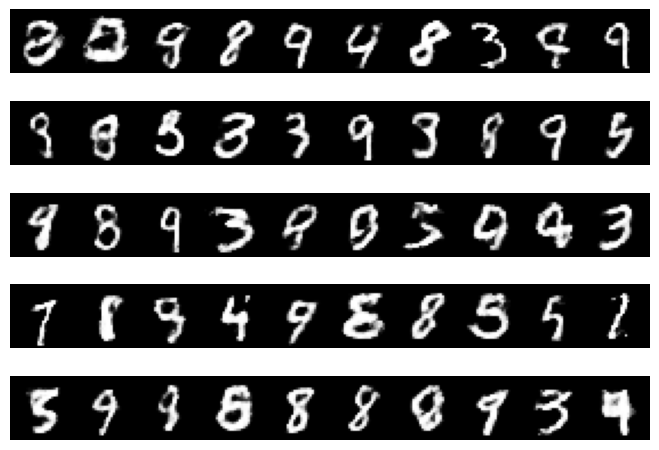

In [21]:


fig, ax = plt.subplots(nrows = 5, ncols = 10)
for i , axi in enumerate(ax.flat):
  axi.imshow(np.array(generated_data[i]).reshape(28,28), cmap = 'grey')
  #axi.set_title('Label: {}'.format(y_train[i]))
  axi.axis('off')
plt.tight_layout(pad  = 0)
plt.show()

In [22]:
#Generator
#load the saved version
gen1 = Generator(laten_dim)

In [23]:
gen1.load_weights('./generator_weights.weights.h5')

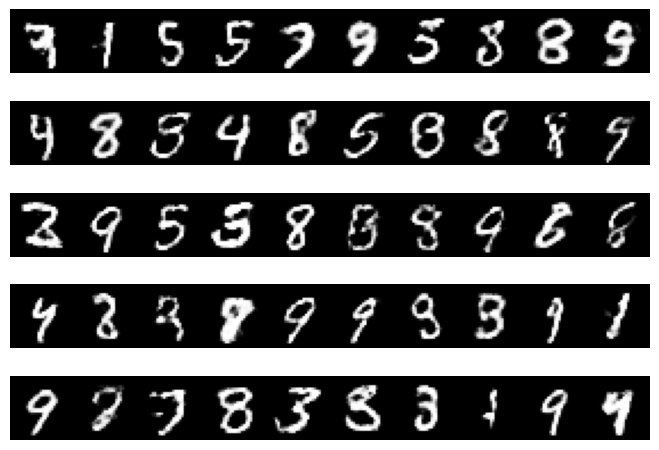

In [25]:
noise = tf.random.normal(shape = (50, 60))

 #discriminator operations
generated_data = gen1(noise)

fig, ax = plt.subplots(nrows = 5, ncols = 10)
for i , axi in enumerate(ax.flat):
  axi.imshow(np.array(generated_data[i]).reshape(28,28), cmap = 'grey')
  #axi.set_title('Label: {}'.format(y_train[i]))
  axi.axis('off')
plt.tight_layout(pad  = 0)
plt.show()

In [27]:
#we need to save the model itself to run the code from here:
gan.generator.save('/content/drive/My Drive/GAN_images/final_generator_model.keras')

In [28]:
#we need to save the model itself to run the code from here:
gan.discriminator.save('/content/drive/My Drive/GAN_images/final_discriminator_model.keras')

In [ ]:
#in next time run from here, or we can use another file to run theses codes.

In [3]:
#to save the model to link drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
#build generator:
class Generator(tf.keras.Model):
  def __init__(self,z_dim = 100, data_dim = 28*28):
    super(Generator, self).__init__()
    self.z_dim = z_dim
    self.data_dim = data_dim
    self.net = tf.keras.Sequential([
        tf.keras.layers.Input(shape =(self.z_dim,)),
        #tf.keras.layers.Dense(units = 256, activation = 'relu'),
        tf.keras.layers.Dense(units = 512, activation = 'relu'),
        tf.keras.layers.Dense(units = self.data_dim , activation = 'sigmoid')
    ])
  def call(self, x):
    return self.net(x)

laten_dim=60
gen2 = Generator(laten_dim)

In [13]:
gen2

<Generator name=generator_2, built=False>

In [16]:
#load the weigths
gen2.load_weights('/content/drive/My Drive/GAN_images/gan_model_at_epoch_0900.h5ganerator_weights_at_epoch_0900.weights.h5')

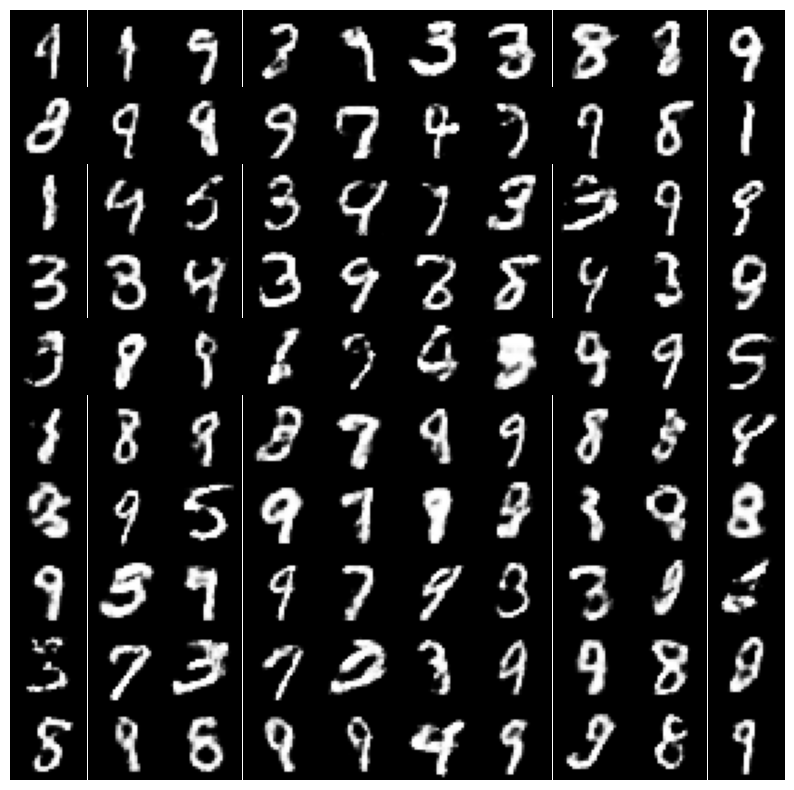

In [20]:
noise = tf.random.normal(shape = (100, 60))
gen_imgs = gen2(noise)
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(10, 10),
                      # Remove padding and spaces
                      gridspec_kw={'wspace': 0, 'hspace': 0},
                      # Remove subplot margins
                      subplot_kw={'aspect': 'equal'}) # Ensure square aspect ratio for images

for i, ax in enumerate(axs.flat):
  ax.imshow(gen_imgs[i].numpy().reshape(28, 28), cmap='gray')
  ax.axis('off')

In [ ]:
#in next time, we need to save whole model so we don't need to define class again,
#in training time , use another metric and draw there metric over training process